In [102]:
import pandas as pd
import importlib
import seaborn as sns
import preprocessing
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from models import vader_sa as vader
from models import afinn_sa as afinn
from models import hyperopt_pt as optimizer
import utils
importlib.reload(optimizer)

<module 'models.hyperopt_pt' from 'c:\\Users\\venug\\Desktop\\antivax_sa\\models\\hyperopt_pt.py'>

# Agenda
<ol>

<li> Create method for basic cleaning, removing retweet tags,etc. </li>
<li> Create method for POS tagging and lemmatization </li>
<li> Run Sentiment analysis on data with basic cleaning using Vader and Afinn. </li>
<li> Train multiple classifiers including Naive Bayes and SVMs on the data. Use HyperOpt for hyperparameter tuning. Also selecting the best model using HyperOpt-sklearn. </li>
<li> Write method to tag messages as neutral if average classification probability in the neighbourhood of 0.5, possibly give more weightage to Vader/Affin output </li>
<li> Setup twitter api to get the entire tweets using tweet ids. Use tweepy to connect to twitter api. </li>
<li> Setup apis for fb and reddit to be able to access vaccine related posts to enhance model. </li>

In [35]:
preprocessor = preprocessing.Preprocessor()

In [151]:
df_tweets = pd.read_csv(r'./data/vaccine_labeled_tweets.csv',index_col=0)

In [39]:
df_pro = pd.read_csv(r'./data/vaccine_pro.csv')
df_pro.describe()
# df_pro['message'].drop_duplicates()

,tweetid,inreplyuserid,friendscount,userid,favoritecount,followerscount,inreplytweetid,retweetcount,annotation
count,1.000000e+04,1.000000e+04,10000.000000,1.000000e+04,10000.0,1.000000e+04,1.000000e+04,10000.0,10000.0
mean,1.383379e+18,4.807362e+16,1303.354900,4.815039e+17,0.0,1.273950e+04,1.766206e+17,0.0,1.0
std,2.890019e+13,2.334947e+17,4606.207082,5.685077e+17,0.0,1.988503e+05,4.616376e+17,0.0,0.0
min,1.383327e+18,-1.000000e+00,0.000000,1.406830e+05,0.0,0.000000e+00,-1.000000e+00,0.0,1.0
25%,1.383355e+18,-1.000000e+00,192.000000,3.300326e+08,0.0,8.600000e+01,-1.000000e+00,0.0,1.0
50%,1.383378e+18,-1.000000e+00,488.000000,2.926940e+09,0.0,3.250000e+02,-1.000000e+00,0.0,1.0
75%,1.383404e+18,-1.000000e+00,1253.250000,1.094894e+18,0.0,1.279250e+03,-1.000000e+00,0.0,1.0
max,1.383427e+18,1.382914e+18,272394.000000,1.383424e+18,0.0,7.832936e+06,1.383427e+18,0.0,1.0


In [40]:
df_anti = pd.read_csv(r'./data/vaccine_anti.csv')
# df_anti['message'].drop_duplicates()

In [41]:
df_anti.columns

Index(['tweetid', 'name', 'inreplyuserid', 'createdat', 'timezone',
       'friendscount', 'accountcreated', 'location', 'userid', 'xcoordinate',
       'message', 'screenname', 'favoritecount', 'followerscount',
       'inreplytweetid', 'retweetcount', 'utcoffset', 'ycoordinate',
       'dataagent', 'place', 'inreplyscreenname', 'category', 'annotation'],
      dtype='object')

In [42]:
df_tweetData = df_pro[['message','annotation']].drop_duplicates()
df_neg = df_anti[['message','annotation']].drop_duplicates()
df_tweetData = df_tweetData.append(df_neg,ignore_index = True)

In [43]:
preprocessor.simple_clean(df_tweetData,'message','message_cleaned')
preprocessor.clean_tweets(df_tweetData,'message_cleaned','message_tokenized')
preprocessor.lemmatize_tweets(df_tweetData,'message_tokenized','message_tokens_lemmatized')

In [44]:
df_tweetData

,message,annotation,retweeted_from,mentions,hashtags,links,message_cleaned,message_tokenized,message_tokens_lemmatized
0,RT @DrEricDing: 📍Huge—Latin America’s main Sin...,1,[RT @DrEricDing:],[DrEricDing],[COVID19],[],Huge Latin America s main Sinovac CoronaVac ...,"[Huge, Latin, America, main, Sinovac, CoronaVa...","[huge, latin, america, main, sinovac, coronava..."
1,@virsanghvi The competencies and qualification...,1,[],[virsanghvi],[],[],The competencies and qualifications of ministe...,"[competencies, qualifications, ministers, well...","[competency, qualification, minister, well, kn..."
2,First vaccination = done. https://t.co/MG0mFnrG9q,1,[],[],[],[https://t.co/MG0mFnrG9q],First vaccination done,"[First, vaccination, done]","[first, vaccination, do]"
3,@SreeIyer1 @Swamy39 Now let$q$s focus on threa...,1,[],"[SreeIyer1, Swamy39]",[],[],Now let q s focus on threat of Covaxin also Pe...,"[let, q, focus, threat, Covaxin, also, People,...","[let, q, focus, threat, covaxin, also, people,..."
4,@Cpgaf1 @SenSchumer I agree with pausing the J...,1,[],"[Cpgaf1, SenSchumer]",[],[],I agree with pausing the J J vaccine but I al...,"[agree, pausing, J, J, vaccine, also, think, n...","[agree, pause, j, j, vaccine, also, think, nee..."
...,...,...,...,...,...,...,...,...,...
8309,"Ayrshire woman demands answers after son, 20, ...",-1,[],[],[],[https://t.co/mMSCBKnVk0],Ayrshire woman demands answers after son 20 ...,"[Ayrshire, woman, demands, answers, son, 20, d...","[ayrshire, woman, demand, answer, son, 20, dy,..."
8310,The failure to secure sufficient vaccine suppl...,-1,[],[],[],[https://t.co/IaGwcdTTfQ],The failure to secure sufficient vaccine suppl...,"[failure, secure, sufficient, vaccine, supply,...","[failure, secure, sufficient, vaccine, supply,..."
8311,@libtard_cuck @ProlongingCovid @snowride70 The...,-1,[],"[libtard_cuck, ProlongingCovid, snowride70]",[],[],The conspiracy theory that includes economic c...,"[conspiracy, theory, includes, economic, colla...","[conspiracy, theory, include, economic, collap..."
8312,@WFIUNews WEDNESDAY INDIANA #COVID19 VACCINE N...,-1,[],[WFIUNews],[COVID19],[],WEDNESDAY INDIANA COVID19 VACCINE NUMBERS ...,"[WEDNESDAY, INDIANA, COVID19, VACCINE, NUMBERS...","[wednesday, indiana, covid19, vaccine, numbers..."


## VADER & afinn based sentiment analysis

In [45]:
df_vader = vader.sentiment_scores(df_tweetData,'message_cleaned')
df_vader.columns = 'vader_' + df_vader.columns
df_tweetData = df_tweetData.join(df_vader)
afinn.sentiment_scores(df_tweetData,'message_cleaned')
df_tweetData

,message,annotation,retweeted_from,mentions,hashtags,links,message_cleaned,message_tokenized,message_tokens_lemmatized,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score
0,RT @DrEricDing: 📍Huge—Latin America’s main Sin...,1,[RT @DrEricDing:],[DrEricDing],[COVID19],[],Huge Latin America s main Sinovac CoronaVac ...,"[Huge, Latin, America, main, Sinovac, CoronaVa...","[huge, latin, america, main, sinovac, coronava...","{'neg': 0.049, 'neu': 0.711, 'pos': 0.24, 'com...",0.049,0.711,0.240,0.6486,0.0
1,@virsanghvi The competencies and qualification...,1,[],[virsanghvi],[],[],The competencies and qualifications of ministe...,"[competencies, qualifications, ministers, well...","[competency, qualification, minister, well, kn...","{'neg': 0.0, 'neu': 0.784, 'pos': 0.216, 'comp...",0.000,0.784,0.216,0.8910,8.0
2,First vaccination = done. https://t.co/MG0mFnrG9q,1,[],[],[],[https://t.co/MG0mFnrG9q],First vaccination done,"[First, vaccination, done]","[first, vaccination, do]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0
3,@SreeIyer1 @Swamy39 Now let$q$s focus on threa...,1,[],"[SreeIyer1, Swamy39]",[],[],Now let q s focus on threat of Covaxin also Pe...,"[let, q, focus, threat, Covaxin, also, People,...","[let, q, focus, threat, covaxin, also, people,...","{'neg': 0.103, 'neu': 0.758, 'pos': 0.139, 'co...",0.103,0.758,0.139,0.0516,-1.0
4,@Cpgaf1 @SenSchumer I agree with pausing the J...,1,[],"[Cpgaf1, SenSchumer]",[],[],I agree with pausing the J J vaccine but I al...,"[agree, pausing, J, J, vaccine, also, think, n...","[agree, pause, j, j, vaccine, also, think, nee...","{'neg': 0.054, 'neu': 0.834, 'pos': 0.112, 'co...",0.054,0.834,0.112,0.3291,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8309,"Ayrshire woman demands answers after son, 20, ...",-1,[],[],[],[https://t.co/mMSCBKnVk0],Ayrshire woman demands answers after son 20 ...,"[Ayrshire, woman, demands, answers, son, 20, d...","[ayrshire, woman, demand, answer, son, 20, dy,...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,-1.0
8310,The failure to secure sufficient vaccine suppl...,-1,[],[],[],[https://t.co/IaGwcdTTfQ],The failure to secure sufficient vaccine suppl...,"[failure, secure, sufficient, vaccine, supply,...","[failure, secure, sufficient, vaccine, supply,...","{'neg': 0.261, 'neu': 0.662, 'pos': 0.077, 'co...",0.261,0.662,0.077,-0.8625,-9.0
8311,@libtard_cuck @ProlongingCovid @snowride70 The...,-1,[],"[libtard_cuck, ProlongingCovid, snowride70]",[],[],The conspiracy theory that includes economic c...,"[conspiracy, theory, includes, economic, colla...","[conspiracy, theory, include, economic, collap...","{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",0.375,0.625,0.000,-0.8625,-6.0
8312,@WFIUNews WEDNESDAY INDIANA #COVID19 VACCINE N...,-1,[],[WFIUNews],[COVID19],[],WEDNESDAY INDIANA COVID19 VACCINE NUMBERS ...,"[WEDNESDAY, INDIANA, COVID19, VACCINE, NUMBERS...","[wednesday, indiana, covid19, vaccine, numbers...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,1.000,0.000,0.0000,0.0


## Bayesian Hyperparameter tuning for various ML models
### Models included: 'svm','naive_bayes','knn','random_forest','decision_tree'
### Models trained using 5 fold stratified CV. 
### Number of Features also treated as a Hyperparameter.


In [169]:
NB = optimizer.optimize_model(model = 'naive_bayes', algo = tpe.suggest,max_evals = 50,df = df_tweetData,message_tokenized = 'message_tokens_lemmatized',x = 'feature',y='annotation')
NB.get_optimum_hyperparameters()

100%|██████████| 50/50 [02:17<00:00,  2.74s/trial, best loss: -0.8581922829502885]


({'alpha': 1.5976361142068052, 'numFeatures': 2124},
 <hyperopt.base.Trials at 0x2ab9317c888>)

In [51]:
randomForest = optimizer.optimize_model(model = 'random_forest', algo = tpe.suggest,max_evals = 50,df = df_tweetData,message_tokenized = 'message_tokens_lemmatized',x = 'feature',y='annotation')
randomForest.get_optimum_hyperparameters()

100%|██████████| 50/50 [01:03<00:00,  1.26s/trial, best loss: -0.7957669327393913]


({'criterion': 1,
  'max_depth': 14,
  'max_features': 2,
  'n_estimators': 16,
  'numFeatures': 194},
 <hyperopt.base.Trials at 0x2abdcb49488>)

In [157]:
SVC = optimizer.optimize_model(model = 'svm', algo = tpe.suggest,max_evals = 50,df = df_tweetData,message_tokenized = 'message_tokens_lemmatized',x = 'feature',y='annotation')
SVC.get_optimum_hyperparameters()

In [48]:
decision_tree = optimizer.optimize_model(model = 'decision_tree', algo = tpe.suggest,max_evals = 50,df = df_tweetData,message_tokenized = 'message_tokens_lemmatized',x = 'feature',y='annotation')
decision_tree.get_optimum_hyperparameters()

100%|██████████| 50/50 [07:30<00:00,  9.01s/trial, best loss: -0.7522255822014207]


({'criterion': 0, 'max_depth': 17, 'numFeatures': 1858},
 <hyperopt.base.Trials at 0x2abd92fb588>)

In [49]:
knn = optimizer.optimize_model(model = 'knn', algo = tpe.suggest,max_evals = 50,df = df_tweetData,message_tokenized = 'message_tokens_lemmatized',x = 'feature',y='annotation')
knn.get_optimum_hyperparameters()

100%|██████████| 50/50 [2:18:20<00:00, 166.01s/trial, best loss: -0.7430858357701021]


({'knn_n_neighbors': 5, 'numFeatures': 953},
 <hyperopt.base.Trials at 0x2abd94a7f08>)

Word Cloud Saved Successfully


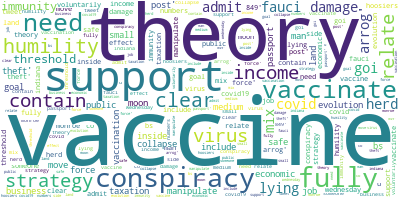

In [65]:
utils.create_wordcloud(df_tweetData.loc[df_tweetData['annotation'] == -1,'lemmatized_message'].values,'wc_neg')

## Preparing Test Data

In [152]:
preprocessor.simple_clean(df_tweets,'Tweet','message_cleaned')
preprocessor.clean_tweets(df_tweets,'message_cleaned','message_tokenized')
preprocessor.lemmatize_tweets(df_tweets,'message_tokenized','message_tokens_lemmatized')

In [153]:
df_tweets.loc[df_tweets['Nour_label'] == 1,'annotation'] = -1
df_tweets.loc[df_tweets['Nour_label'] == 2,'annotation'] = 1



In [154]:
df_tweets_test = df_tweets[(df_tweets['annotation'] == 1) | (df_tweets['annotation'] == -1)]

In [155]:
df_tweets_test['lemmatized_message'] = df_tweets_test['message_tokens_lemmatized'].apply(lambda x: " ".join(x))

ipykernel_launcher:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [136]:
##### get Bernoulli NB classifier and stratified cv scores trained on optimum parameters
params = {
    'alpha': 1.2164719490595255, 'numFeatures': 2500
}
scores_NB,clf = NB.train_model(params,get_model=True)
scores_NB

array([0.84485869, 0.84906795, 0.86951293, 0.85508118, 0.87063779])

In [137]:
X = NB.count_vec.transform(df_tweets_test['lemmatized_message'].values)

In [138]:
X_test = X.todense()
y_test = df_tweets_test['annotation'].values

In [139]:
clf.score(X_test,y_test)

0.6791979949874687

In [145]:
df_tweets_test = df_tweets_test.reset_index()

In [ ]:
##### get Bernoulli NB classifier and stratified cv scores trained on optimum parameters
params = {
    'alpha': 1.2164719490595255, 'numFeatures': 2500
}
scores_NB,clf = NB.train_model(params,get_model=True)
scores_NB

In [159]:
params = {'C': 0.7688125245234239,
  'gamma': 18.62738748302337,
  'kernel': 'linear',
  'numFeatures': 2189}
SVC_scores,clf_SVC = SVC.train_model(params,get_model = True)
SVC_scores

array([0.85508118, 0.86470235, 0.87853277, 0.8634997 , 0.877858  ])

In [166]:
X = SVC.count_vec.transform(df_tweets_test['lemmatized_message'].values)
X_test = X.todense()
y_test = df_tweets_test['annotation'].values

In [167]:
clf_SVC.score(X_test,y_test)

0.6466165413533834

In [168]:
df_vader_SVC = vader.sentiment_scores(df_tweets_test,'message_cleaned')
df_vader_SVC.columns = 'vader_' + df_vader_SVC.columns
df_tweets_test = df_tweets_test.join(df_vader)
afinn.sentiment_scores(df_tweets_test,'message_cleaned')
df_tweets_test

c:\Users\venug\Desktop\antivax_sa\models\vader_sa.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['vader_dict'] = df[message_cleaned].apply(sid_obj.polarity_scores)


,Tweet,Nour_label,retweeted_from,mentions,hashtags,links,message_cleaned,message_tokenized,message_tokens_lemmatized,annotation,lemmatized_message,vader_dict,vader_neg,vader_neu,vader_pos,vader_compound,afinn_score
4,@growthpundit @naomirwolf There is no such thi...,2,[],"[growthpundit, naomirwolf]",[],[],There is no such thing as herd immunity unless...,"[thing, herd, immunity, unless, vaccine]","[thing, herd, immunity, unless, vaccine]",1.0,thing herd immunity unless vaccine,"{'neg': 0.155, 'neu': 0.845, 'pos': 0.0, 'comp...",0.054,0.834,0.112,0.3291,-1.0
6,"So called ""anti-vax"" movement is a movement to...",1,[],[],"[vaccine, HumanRights, InformedConsent]",[https://t.co/ep3rZcRfzT],So called anti vax movement is a movement to...,"[called, anti, vax, movement, movement, acknow...","[call, anti, vax, movement, movement, acknowle...",-1.0,call anti vax movement movement acknowledge va...,"{'neg': 0.239, 'neu': 0.551, 'pos': 0.21, 'com...",0.000,0.904,0.096,0.1779,-4.0
8,You know you’ve been tricked when you want the...,1,[],[],[],[],You know you ve been tricked when you want the...,"[know, tricked, want, thing, news, media, want...","[know, trick, want, thing, news, medium, want,...",-1.0,know trick want thing news medium want like bi...,"{'neg': 0.054, 'neu': 0.816, 'pos': 0.129, 'co...",0.000,0.718,0.282,0.7425,1.0
13,RT @Saveitbruh: Still ain’t taking no vaccine ...,1,[RT @Saveitbruh:],[Saveitbruh],[],[],Still ain t taking no vaccine if that shit e...,"[Still, taking, vaccine, shit, ever, come]","[still, take, vaccine, shit, ever, come]",-1.0,still take vaccine shit ever come,"{'neg': 0.367, 'neu': 0.633, 'pos': 0.0, 'comp...",0.174,0.717,0.109,-0.1779,-5.0
14,"The news is saying ""there is no evidence of vo...",1,[],[],[],[],The news is saying there is no evidence of vo...,"[news, saying, evidence, voter, fraud, Sounds,...","[news, say, evidence, voter, fraud, sounds, li...",-1.0,news say evidence voter fraud sounds like say ...,"{'neg': 0.219, 'neu': 0.68, 'pos': 0.1, 'compo...",0.000,1.000,0.000,0.0000,-5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2986,@yea_karen53 @StephMatuku @naomirwolf Herd imm...,2,[],"[yea_karen53, StephMatuku, naomirwolf]",[],[],Herd immunity is literally how humanity has ov...,"[Herd, immunity, literally, humanity, overcome...","[herd, immunity, literally, humanity, overcome...",1.0,herd immunity literally humanity overcome ever...,"{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compou...",0.097,0.783,0.120,0.1280,2.0
2989,@WarHorseOnStage Some w/ life-threatening cond...,2,[],[WarHorseOnStage],[],[],Some w life threatening conditions will still...,"[w, life, threatening, conditions, still, quar...","[w, life, threaten, condition, still, quaranti...",1.0,w life threaten condition still quarantine awa...,"{'neg': 0.092, 'neu': 0.643, 'pos': 0.264, 'co...",0.093,0.717,0.190,0.5574,8.0
2991,@CacAnna @caaiinaa @Hugo80036337 @o_rips They’...,1,[],"[CacAnna, caaiinaa, Hugo80036337, o_rips, DrJu...",[],[],They re already admitting to the nanotechnolog...,"[already, admitting, nanotechnology, dna, alte...","[already, admit, nanotechnology, dna, alter, n...",-1.0,already admit nanotechnology dna alter nature ...,"{'neg': 0.116, 'neu': 0.763, 'pos': 0.121, 'co...",0.000,0.767,0.233,0.7717,1.0
2995,"Yes, vaccines cause autism if you let black pe...",1,[],[],[],[],Yes vaccines cause autism if you let black pe...,"[Yes, vaccines, cause, autism, let, black, peo...","[yes, vaccine, cause, autism, let, black, peop...",-1.0,yes vaccine cause autism let black people expl...,"{'neg': 0.0, 'neu': 0.94, 'pos': 0.06, 'compou...",0.000,0.820,0.180,0.5106,1.0
